In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model

# The goal of this Notebook is to learn how to work with **Time series data** using as example the **Bitcoin** case 

# Gettin the data
https://dev.mrdbourke.com/tensorflow-deep-learning/10_time_series_forecasting_in_tensorflow/

In [2]:
# Download Bitcoin historical data from GitHub 
# Note: you'll need to select "Raw" to download the data in the correct format
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv 

--2023-04-06 08:12:24--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 178509 (174K) [text/plain]
Saving to: ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv’

BTC_USD_2013-10-01_ 100%[===================>] 174.33K  --.-KB/s    in 0.008s  

2023-04-06 08:12:25 (20.5 MB/s) - ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv’ saved [178509/178509]



In [3]:
# Parse dates and set date column to index
df = pd.read_csv("/content/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv", 
                 parse_dates=["Date"], 
                 index_col=["Date"]) # parse the date column (tell pandas column 1 is a datetime)
df.head()

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2013-10-01,BTC,123.65499,124.30466,124.75166,122.56349
2013-10-02,BTC,125.45500,123.65499,125.75850,123.63383
2013-10-03,BTC,108.58483,125.45500,125.66566,83.32833
2013-10-04,BTC,118.67466,108.58483,118.67500,107.05816
2013-10-05,BTC,121.33866,118.67466,121.93633,118.00566


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2787 entries, 2013-10-01 to 2021-05-18
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Currency             2787 non-null   object 
 1   Closing Price (USD)  2787 non-null   float64
 2   24h Open (USD)       2787 non-null   float64
 3   24h High (USD)       2787 non-null   float64
 4   24h Low (USD)        2787 non-null   float64
dtypes: float64(4), object(1)
memory usage: 130.6+ KB


#Defintion: The frequency at which a time series value is collected is often referred to as **seasonality**. This is usually mesaured in number of samples per year. For example, collecting the price of Bitcoin once per day would result in a time series with a seasonality of 365.

In [5]:
# Only want closing price for each day 
bitcoin_prices = pd.DataFrame(df["Closing Price (USD)"]).rename(columns={"Closing Price (USD)": "Price"})
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


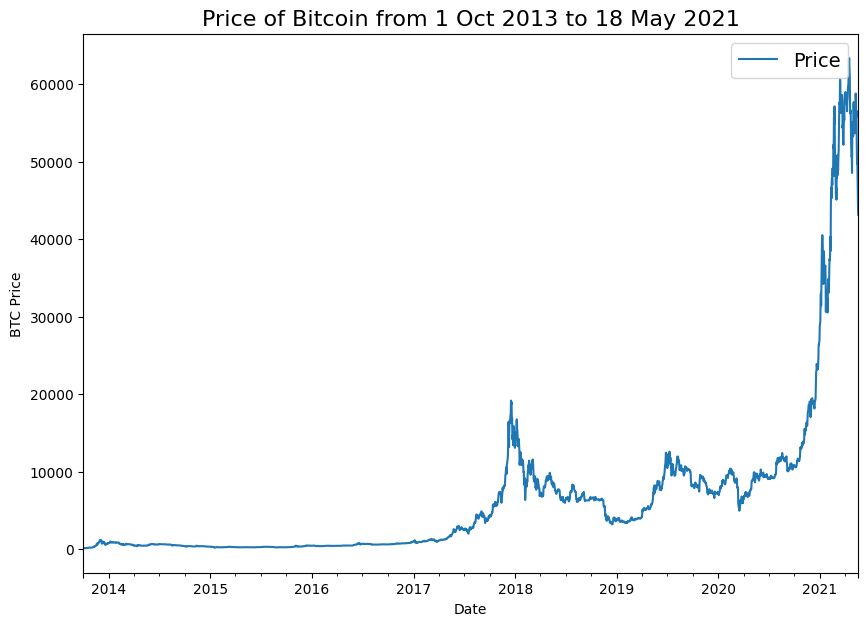

In [6]:
bitcoin_prices.plot(figsize=(10, 7))
plt.ylabel("BTC Price")
plt.title("Price of Bitcoin from 1 Oct 2013 to 18 May 2021", fontsize=16)
plt.legend(fontsize=14);

#Format Data Part 1: Creatining train and test sets for time series data¶


Usually, you could create a train and test split using a function like Scikit-Learn's outstanding train_test_split() but as we'll see in a moment, this doesn't really cut it for time series data.

In [7]:
# Get bitcoin date array
timesteps = bitcoin_prices.index.to_numpy()
prices = bitcoin_prices["Price"].to_numpy()

In [8]:
# Create train and test splits the right way for time series data
split_size = int(0.8 * len(prices)) # 80% train, 20% test
# Create train data splits (everything before the split)
X_train, y_train = timesteps[:split_size], prices[:split_size]

# Create test data splits (everything after the split)
X_test, y_test = timesteps[split_size:], prices[split_size:]

len(X_train), len(X_test), len(y_train), len(y_test)

(2229, 558, 2229, 558)

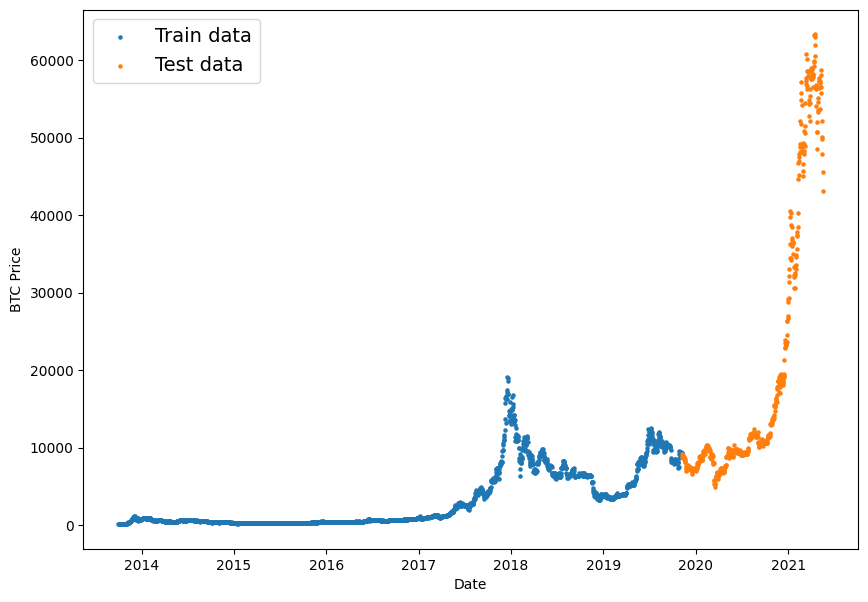

In [9]:
# Plot correctly made splits
plt.figure(figsize=(10, 7))
plt.scatter(X_train, y_train, s=5, label="Train data")
plt.scatter(X_test, y_test, s=5, label="Test data")
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.legend(fontsize=14)
plt.show();

# Defining function to make recurrent plots

In [10]:
# Create a function to plot time series data
def plot_time_series(timesteps, values, format='.', start=0, end=None, label=None):
  """
  Plots a timesteps (a series of points in time) against values (a series of values across timesteps).
  
  Parameters
  ---------
  timesteps : array of timesteps
  values : array of values across time
  format : style of plot, default "."
  start : where to start the plot (setting a value will index from start of timesteps & values)
  end : where to end the plot (setting a value will index from end of timesteps & values)
  label : label to show on plot of values
  """
  # Plot the series
  plt.plot(timesteps[start:end], values[start:end], format, label=label)
  plt.xlabel("Time")
  plt.ylabel("BTC Price")
  if label:
    plt.legend(fontsize=14) # make label bigger
  plt.grid(True)

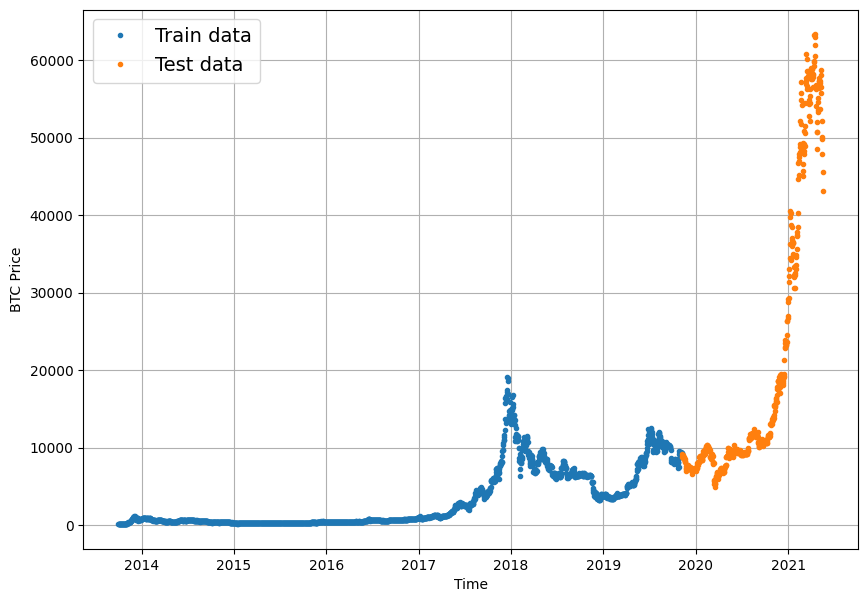

In [11]:

# Try out our plotting function
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train, values=y_train, label="Train data")
plot_time_series(timesteps=X_test, values=y_test, label="Test data")

# **Modelling experiments**

**Definitions**

* **horizon** = number of timesteps to predict into future
* **window** = number of timesteps from past used to predict horizon

# Model 0: Naïve forecast (baseline)

It requires no training at all.

That's because all the naïve model does is use the previous timestep value to predict the next timestep value.

The formula looks like this:

$\bar{y}_t = y_{t-1}$

In English:

The prediction at timestep t (y-hat) is equal to the value at timestep t-1 (the previous timestep)

**In an open system (like a stock market or crypto market), you'll often find beating the naïve forecast with any kind of model is quite hard**

Time series forecasting in **open systems** (the value is not restricted) is generally **quite poor**.

In [12]:
# Create a naïve forecast
naive_forecast = y_test[:-1] # Naïve forecast equals every value excluding the last value
naive_forecast[:10], naive_forecast[-10:] # View frist 10 and last 10

(array([9226.48582088, 8794.35864452, 8798.04205463, 9081.18687849,
        8711.53433917, 8760.89271814, 8749.52059102, 8656.97092235,
        8500.64355816, 8469.2608989 ]),
 array([57107.12067189, 58788.20967893, 58102.19142623, 55715.54665129,
        56573.5554719 , 52147.82118698, 49764.1320816 , 50032.69313676,
        47885.62525472, 45604.61575361]))

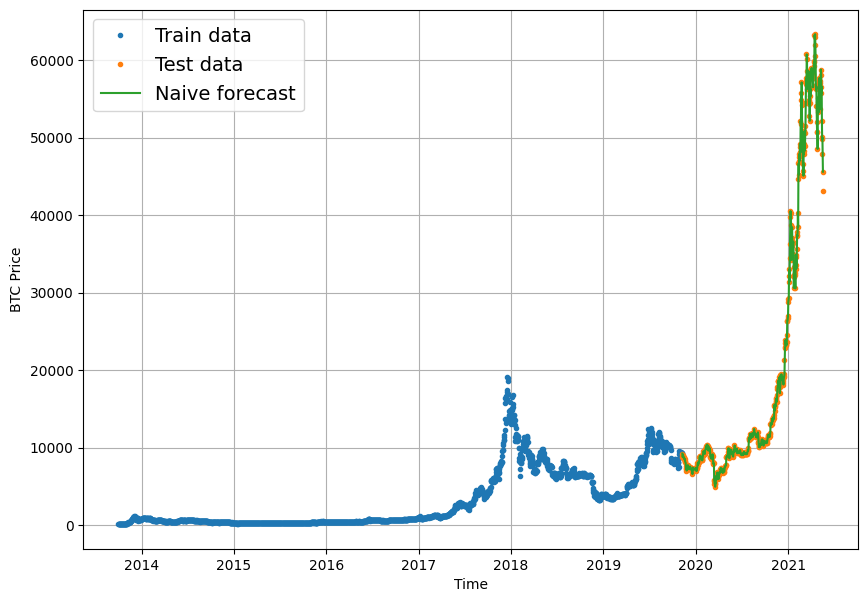

In [13]:
# Plot naive forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train, values=y_train, label="Train data")
plot_time_series(timesteps=X_test, values=y_test, label="Test data")
plot_time_series(timesteps=X_test[1:], values=naive_forecast, format="-", label="Naive forecast");

since TensorFlow doesn't have a ready made version of MASE (mean aboslute scaled error), how about we create our own?

We'll take inspiration from sktime's (Scikit-Learn for time series) MeanAbsoluteScaledError class which calculates the MASE.

In [14]:
# MASE implemented courtesy of sktime - https://github.com/alan-turing-institute/sktime/blob/ee7a06843a44f4aaec7582d847e36073a9ab0566/sktime/performance_metrics/forecasting/_functions.py#L16
def mean_absolute_scaled_error(y_true, y_pred):
  """
  Implement MASE (assuming no seasonality of data).
  """
  mae = tf.reduce_mean(tf.abs(y_true - y_pred))

  # Find MAE of naive forecast (no seasonality)
  mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1])) # our seasonality is 1 day (hence the shifting of 1 day)

  return mae / mae_naive_no_season

You'll notice the version of MASE above doesn't take in the training values like sktime's mae_loss(). In our case, we're comparing the MAE of our predictions on the test to the MAE of the naïve forecast on the test set.

In practice, if we've created the function correctly, the naïve model should achieve an MASE of 1 (or very close to 1). Any model worse than the naïve forecast will achieve an MASE of >1 and any model better than the naïve forecast will achieve an MASE of <1.

In [15]:
def evaluate_preds(y_true, y_pred):
  # Make sure float32 (for metric calculations)
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate various metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred) # puts and emphasis on outliers (all errors get squared)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)
  
  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}

Testing our metrics in the Bayes forecast

In [16]:
naive_results = evaluate_preds(y_true=y_test[1:],
                               y_pred=naive_forecast)
naive_results

{'mae': 567.9802,
 'mse': 1147547.0,
 'rmse': 1071.2362,
 'mape': 2.516525,
 'mase': 0.99957}

For **Bayes** 'mase' will be 1, any model better that this will achieve a 'mase'<1

According to our metrics, bayes gives a error of approximately 567.9802 dolars.
Let's compare that with the mean value of bitcoin

In [17]:
# Find average price of Bitcoin in test dataset
tf.reduce_mean(y_test).numpy()

20056.632963737222

#  Format Data Part 2: Windowing dataset

Windowing is a method to turn a time series dataset into supervised learning problem.

In other words, we want to use windows of the past to predict the future

Let's build some functions which take in a univariate time series and turn it into windows and horizons of specified sizes.

In [18]:

HORIZON = 1 # predict 1 step at a time
WINDOW_SIZE = 7 # use a week worth of timesteps to predict the horizon

In [19]:
# Create function to label windowed data
def get_labelled_windows(x, horizon=1):
  """
  Creates labels for windowed dataset.

  E.g. if horizon=1 (default)
  Input: [1, 2, 3, 4, 5, 6] -> Output: ([1, 2, 3, 4, 5], [6])
  """
  return x[:, :-horizon], x[:, -horizon:]

In [20]:
# Create function to view NumPy arrays as windows 
def make_windows(x, window_size=7, horizon=1):
  """
  Turns a 1D array into a 2D array of sequential windows of window_size.
  """
  # 1. Create a window of specific window_size (add the horizon on the end for later labelling)
  window_step = np.expand_dims(np.arange(window_size+horizon), axis=0)
  # print(f"Window step:\n {window_step}")

  # 2. Create a 2D array of multiple window steps (minus 1 to account for 0 indexing)
  window_indexes = window_step + np.expand_dims(np.arange(len(x)-(window_size+horizon-1)), axis=0).T # create 2D array of windows of size window_size
  # print(f"Window indexes:\n {window_indexes[:3], window_indexes[-3:], window_indexes.shape}")

  # 3. Index on the target array (time series) with 2D array of multiple window steps
  windowed_array = x[window_indexes]

  # 4. Get the labelled windows
  windows, labels = get_labelled_windows(windowed_array, horizon=horizon)

  return windows, labels

In [21]:
np.expand_dims(np.arange(7+1), axis=0)

array([[0, 1, 2, 3, 4, 5, 6, 7]])

In [22]:

np.expand_dims(np.arange(12-(8-1)), axis=0).T

array([[0],
       [1],
       [2],
       [3],
       [4]])

In [23]:
np.expand_dims(np.arange(7+1), axis=0) + np.expand_dims(np.arange(12-(8-1)), axis=0).T

array([[ 0,  1,  2,  3,  4,  5,  6,  7],
       [ 1,  2,  3,  4,  5,  6,  7,  8],
       [ 2,  3,  4,  5,  6,  7,  8,  9],
       [ 3,  4,  5,  6,  7,  8,  9, 10],
       [ 4,  5,  6,  7,  8,  9, 10, 11]])

In [24]:
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2780, 2780)

#Turning windows into training and test sets

Let's write a function which takes in full sets of windows and their labels and splits them into train and test splits.



In [25]:
# Make the train/test splits
def make_train_test_splits(windows, labels, test_split=0.2):
  """
  Splits matching pairs of windows and labels into train and test splits.
  """
  split_size = int(len(windows) * (1-test_split)) # this will default to 80% train/20% test
  train_windows = windows[:split_size]
  train_labels = labels[:split_size]
  test_windows = windows[split_size:]
  test_labels = labels[split_size:]
  return train_windows, test_windows, train_labels, test_labels

In [26]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2224, 556, 2224, 556)

### Until now, we have focused only in setting the data in the right way to be used. We haven't analyzed the data or plot it. Just creating our windows and splitting it into training and testing data

### Quite an effort and nothing of models yet

Let's implement some checkpoints!

In [27]:
import os

# Create a function to implement a ModelCheckpoint callback with a specific filename 
def create_model_checkpoint(model_name, save_path="model_experiments"):
  return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name), # create filepath to save model
                                            verbose=0, # only output a limited amount of text
                                            save_best_only=True) # save only the best model to file

# Model 1: Dense model (window = 7, horizon = 1)

In [28]:
model_1 = tf.keras.Sequential([
    layers.Dense(128,activation='relu'),
    layers.Dense(HORIZON, activation = 'linear') # linear activation is the same as having no activation   
], name="model_1_dense")

#Compiling the model
model_1.compile(loss='mae', optimizer = tf.keras.optimizers.Adam(), metrics=['mae'])



In [29]:
model_1.fit(x=train_windows, # train windows of 7 timesteps of Bitcoin prices
            y=train_labels, # horizon value of 1 (using the previous 7 timesteps to predict next day)
            epochs=100,
            verbose=1,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_1.name)]) # create ModelCheckpoint callback to save best model

Epoch 1/100
18/18 [==============================] - ETA: 0s - loss: 2108.0134 - mae: 2108.0134

18/18 [==============================] - 10s 155ms/step - loss: 2108.0134 - mae: 2108.0134 - val_loss: 1844.7369 - val_mae: 1844.7369
Epoch 2/100
13/18 [====================>.........] - ETA: 0s - loss: 390.5757 - mae: 390.5757

18/18 [==============================] - 1s 87ms/step - loss: 350.5663 - mae: 350.5663 - val_loss: 1715.0361 - val_mae: 1715.0361
Epoch 3/100
12/18 [===================>..........] - ETA: 0s - loss: 235.4626 - mae: 235.4626

18/18 [==============================] - 1s 61ms/step - loss: 228.3492 - mae: 228.3492 - val_loss: 1023.0407 - val_mae: 1023.0407
Epoch 4/100
18/18 [==============================] - 0s 9ms/step - loss: 188.0265 - mae: 188.0265 - val_loss: 1080.7153 - val_mae: 1080.7153
Epoch 5/100
 8/18 [============>.................] - ETA: 0s - loss: 180.2531 - mae: 180.2531

18/18 [==============================] - 2s 97ms/step - loss: 179.0625 - mae: 179.0625 - val_loss: 1004.1116 - val_mae: 1004.1116
Epoch 6/100
10/18 [===============>..............] - ETA: 0s - loss: 173.1041 - mae: 173.1041

18/18 [==============================] - 1s 62ms/step - loss: 168.4564 - mae: 168.4564 - val_loss: 961.9894 - val_mae: 961.9894
Epoch 7/100
16/18 [=========================>....] - ETA: 0s - loss: 166.9822 - mae: 166.9822

18/18 [==============================] - 1s 62ms/step - loss: 165.1876 - mae: 165.1876 - val_loss: 900.0481 - val_mae: 900.0481
Epoch 8/100
14/18 [======================>.......] - ETA: 0s - loss: 155.1217 - mae: 155.1217

18/18 [==============================] - 1s 59ms/step - loss: 159.0768 - mae: 159.0768 - val_loss: 888.7521 - val_mae: 888.7521
Epoch 9/100
17/18 [===========================>..] - ETA: 0s - loss: 157.1284 - mae: 157.1284

18/18 [==============================] - 1s 71ms/step - loss: 157.5912 - mae: 157.5912 - val_loss: 851.6347 - val_mae: 851.6346
Epoch 10/100
18/18 [==============================] - 0s 11ms/step - loss: 150.5812 - mae: 150.5812 - val_loss: 895.9948 - val_mae: 895.9948
Epoch 11/100
15/18 [========================>.....] - ETA: 0s - loss: 148.6304 - mae: 148.6304

18/18 [==============================] - 1s 61ms/step - loss: 148.0548 - mae: 148.0548 - val_loss: 843.1038 - val_mae: 843.1038
Epoch 12/100
15/18 [========================>.....] - ETA: 0s - loss: 144.4050 - mae: 144.4050

18/18 [==============================] - 2s 106ms/step - loss: 144.4783 - mae: 144.4783 - val_loss: 793.6219 - val_mae: 793.6219
Epoch 13/100
18/18 [==============================] - ETA: 0s - loss: 136.2037 - mae: 136.2037

18/18 [==============================] - 1s 71ms/step - loss: 136.2037 - mae: 136.2037 - val_loss: 738.4869 - val_mae: 738.4869
Epoch 14/100
17/18 [===========================>..] - ETA: 0s - loss: 132.9337 - mae: 132.9337

18/18 [==============================] - 1s 34ms/step - loss: 132.3669 - mae: 132.3669 - val_loss: 732.3245 - val_mae: 732.3245
Epoch 15/100
 1/18 [>.............................] - ETA: 0s - loss: 156.6748 - mae: 156.6748

18/18 [==============================] - 1s 30ms/step - loss: 131.2455 - mae: 131.2455 - val_loss: 704.6836 - val_mae: 704.6836
Epoch 16/100
18/18 [==============================] - ETA: 0s - loss: 127.9723 - mae: 127.9723

18/18 [==============================] - 1s 31ms/step - loss: 127.9723 - mae: 127.9723 - val_loss: 692.6349 - val_mae: 692.6349
Epoch 17/100
18/18 [==============================] - 0s 5ms/step - loss: 128.3814 - mae: 128.3814 - val_loss: 706.7689 - val_mae: 706.7689
Epoch 18/100
18/18 [==============================] - 0s 5ms/step - loss: 128.8331 - mae: 128.8331 - val_loss: 743.8382 - val_mae: 743.8382
Epoch 19/100
 1/18 [>.............................] - ETA: 0s - loss: 156.7882 - mae: 156.7882

18/18 [==============================] - 1s 31ms/step - loss: 129.4096 - mae: 129.4096 - val_loss: 663.8881 - val_mae: 663.8881
Epoch 20/100
17/18 [===========================>..] - ETA: 0s - loss: 121.8504 - mae: 121.8504

18/18 [==============================] - 1s 30ms/step - loss: 123.9390 - mae: 123.9390 - val_loss: 654.9949 - val_mae: 654.9949
Epoch 21/100
18/18 [==============================] - 0s 5ms/step - loss: 119.4824 - mae: 119.4824 - val_loss: 655.4344 - val_mae: 655.4344
Epoch 22/100
 1/18 [>.............................] - ETA: 0s - loss: 88.7875 - mae: 88.7875

18/18 [==============================] - 1s 29ms/step - loss: 119.1193 - mae: 119.1193 - val_loss: 649.5712 - val_mae: 649.5712
Epoch 23/100
18/18 [==============================] - ETA: 0s - loss: 123.9594 - mae: 123.9594

18/18 [==============================] - 1s 44ms/step - loss: 123.9594 - mae: 123.9594 - val_loss: 635.4027 - val_mae: 635.4027
Epoch 24/100
18/18 [==============================] - 0s 7ms/step - loss: 127.9841 - mae: 127.9841 - val_loss: 647.8875 - val_mae: 647.8875
Epoch 25/100
 1/18 [>.............................] - ETA: 0s - loss: 89.0475 - mae: 89.0475

18/18 [==============================] - 1s 29ms/step - loss: 131.1444 - mae: 131.1444 - val_loss: 632.0244 - val_mae: 632.0244
Epoch 26/100
 1/18 [>.............................] - ETA: 0s - loss: 97.1880 - mae: 97.1880

18/18 [==============================] - 1s 31ms/step - loss: 117.8518 - mae: 117.8518 - val_loss: 620.8080 - val_mae: 620.8080
Epoch 27/100
18/18 [==============================] - 0s 5ms/step - loss: 116.5007 - mae: 116.5007 - val_loss: 625.6221 - val_mae: 625.6221
Epoch 28/100
18/18 [==============================] - 0s 5ms/step - loss: 118.2619 - mae: 118.2619 - val_loss: 628.8033 - val_mae: 628.8033
Epoch 29/100
18/18 [==============================] - 0s 6ms/step - loss: 117.8434 - mae: 117.8434 - val_loss: 653.8105 - val_mae: 653.8105
Epoch 30/100
 1/18 [>.............................] - ETA: 0s - loss: 135.8700 - mae: 135.8700

18/18 [==============================] - 1s 30ms/step - loss: 114.0904 - mae: 114.0904 - val_loss: 609.7559 - val_mae: 609.7559
Epoch 31/100
18/18 [==============================] - 0s 5ms/step - loss: 118.9719 - mae: 118.9719 - val_loss: 655.8568 - val_mae: 655.8568
Epoch 32/100
18/18 [==============================] - 0s 5ms/step - loss: 116.2790 - mae: 116.2790 - val_loss: 643.6040 - val_mae: 643.6040
Epoch 33/100
 1/18 [>.............................] - ETA: 0s - loss: 158.0458 - mae: 158.0458

18/18 [==============================] - 1s 31ms/step - loss: 114.6626 - mae: 114.6626 - val_loss: 606.4796 - val_mae: 606.4796
Epoch 34/100
18/18 [==============================] - ETA: 0s - loss: 113.6080 - mae: 113.6080

18/18 [==============================] - 1s 30ms/step - loss: 113.6080 - mae: 113.6080 - val_loss: 602.6177 - val_mae: 602.6177
Epoch 35/100
 1/18 [>.............................] - ETA: 0s - loss: 95.5688 - mae: 95.5688

18/18 [==============================] - 0s 29ms/step - loss: 115.6543 - mae: 115.6543 - val_loss: 597.6383 - val_mae: 597.6383
Epoch 36/100
18/18 [==============================] - 0s 5ms/step - loss: 112.8910 - mae: 112.8910 - val_loss: 612.7901 - val_mae: 612.7901
Epoch 37/100
18/18 [==============================] - 0s 6ms/step - loss: 112.9751 - mae: 112.9751 - val_loss: 634.5146 - val_mae: 634.5146
Epoch 38/100
18/18 [==============================] - 0s 6ms/step - loss: 112.4448 - mae: 112.4448 - val_loss: 681.1559 - val_mae: 681.1559
Epoch 39/100
18/18 [==============================] - 0s 6ms/step - loss: 115.2967 - mae: 115.2967 - val_loss: 599.2846 - val_mae: 599.2846
Epoch 40/100
18/18 [==============================] - 0s 5ms/step - loss: 114.9493 - mae: 114.9493 - val_loss: 713.1852 - val_mae: 713.1852
Epoch 41/100
18/18 [==============================] - 0s 5ms/step - loss: 115.2235 - mae: 115.2235 - val_loss: 631.3973 - val_mae: 631.3973
Epoch 42/100
18/18 [============

18/18 [==============================] - 1s 31ms/step - loss: 135.5194 - mae: 135.5194 - val_loss: 594.3676 - val_mae: 594.3676
Epoch 44/100
13/18 [====================>.........] - ETA: 0s - loss: 126.3748 - mae: 126.3748

18/18 [==============================] - 1s 44ms/step - loss: 118.6493 - mae: 118.6493 - val_loss: 589.5801 - val_mae: 589.5801
Epoch 45/100
18/18 [==============================] - 0s 7ms/step - loss: 110.4071 - mae: 110.4071 - val_loss: 639.3196 - val_mae: 639.3196
Epoch 46/100
18/18 [==============================] - 0s 8ms/step - loss: 112.6647 - mae: 112.6647 - val_loss: 608.0367 - val_mae: 608.0367
Epoch 47/100
14/18 [======================>.......] - ETA: 0s - loss: 115.1833 - mae: 115.1833

18/18 [==============================] - 1s 44ms/step - loss: 111.8770 - mae: 111.8770 - val_loss: 585.2333 - val_mae: 585.2333
Epoch 48/100
18/18 [==============================] - 0s 8ms/step - loss: 113.7076 - mae: 113.7076 - val_loss: 605.1713 - val_mae: 605.1713
Epoch 49/100
12/18 [===================>..........] - ETA: 0s - loss: 106.8672 - mae: 106.8672

18/18 [==============================] - 1s 37ms/step - loss: 110.0584 - mae: 110.0584 - val_loss: 580.0611 - val_mae: 580.0611
Epoch 50/100
 1/18 [>.............................] - ETA: 0s - loss: 112.7258 - mae: 112.7258

18/18 [==============================] - 0s 29ms/step - loss: 109.7267 - mae: 109.7267 - val_loss: 579.4171 - val_mae: 579.4171
Epoch 51/100
18/18 [==============================] - 0s 5ms/step - loss: 116.7715 - mae: 116.7715 - val_loss: 708.3757 - val_mae: 708.3757
Epoch 52/100
18/18 [==============================] - 0s 5ms/step - loss: 114.0965 - mae: 114.0965 - val_loss: 580.7110 - val_mae: 580.7110
Epoch 53/100
18/18 [==============================] - 0s 4ms/step - loss: 109.5553 - mae: 109.5553 - val_loss: 591.7036 - val_mae: 591.7036
Epoch 54/100
 1/18 [>.............................] - ETA: 0s - loss: 133.9300 - mae: 133.9300

18/18 [==============================] - 0s 29ms/step - loss: 112.7713 - mae: 112.7713 - val_loss: 575.9579 - val_mae: 575.9579
Epoch 55/100
18/18 [==============================] - 0s 5ms/step - loss: 112.0139 - mae: 112.0139 - val_loss: 577.1982 - val_mae: 577.1982
Epoch 56/100
18/18 [==============================] - 0s 5ms/step - loss: 112.3161 - mae: 112.3161 - val_loss: 695.7284 - val_mae: 695.7284
Epoch 57/100
18/18 [==============================] - 0s 4ms/step - loss: 111.2127 - mae: 111.2127 - val_loss: 588.7440 - val_mae: 588.7440
Epoch 58/100
18/18 [==============================] - 0s 5ms/step - loss: 109.3937 - mae: 109.3937 - val_loss: 631.3794 - val_mae: 631.3794
Epoch 59/100
18/18 [==============================] - 0s 5ms/step - loss: 108.5969 - mae: 108.5969 - val_loss: 587.6614 - val_mae: 587.6614
Epoch 60/100
 1/18 [>.............................] - ETA: 0s - loss: 99.6757 - mae: 99.6757

18/18 [==============================] - 1s 41ms/step - loss: 108.8307 - mae: 108.8307 - val_loss: 573.8112 - val_mae: 573.8112
Epoch 61/100
18/18 [==============================] - 0s 5ms/step - loss: 107.6638 - mae: 107.6638 - val_loss: 672.7501 - val_mae: 672.7501
Epoch 62/100
16/18 [=========================>....] - ETA: 0s - loss: 108.5260 - mae: 108.5260

18/18 [==============================] - 1s 30ms/step - loss: 110.4002 - mae: 110.4002 - val_loss: 572.8271 - val_mae: 572.8271
Epoch 63/100
18/18 [==============================] - 0s 6ms/step - loss: 106.9743 - mae: 106.9743 - val_loss: 607.0809 - val_mae: 607.0809
Epoch 64/100
18/18 [==============================] - 0s 4ms/step - loss: 108.2139 - mae: 108.2139 - val_loss: 579.3670 - val_mae: 579.3670
Epoch 65/100
18/18 [==============================] - 0s 5ms/step - loss: 108.6821 - mae: 108.6821 - val_loss: 585.0699 - val_mae: 585.0699
Epoch 66/100
18/18 [==============================] - 0s 5ms/step - loss: 108.8186 - mae: 108.8186 - val_loss: 617.8455 - val_mae: 617.8455
Epoch 67/100
18/18 [==============================] - 0s 5ms/step - loss: 109.0788 - mae: 109.0788 - val_loss: 593.7488 - val_mae: 593.7488
Epoch 68/100
18/18 [==============================] - 0s 6ms/step - loss: 106.5113 - mae: 106.5113 - val_loss: 578.8133 - val_mae: 578.8133
Epoch 69/100
 1/18 [>...........

18/18 [==============================] - 1s 30ms/step - loss: 107.3339 - mae: 107.3339 - val_loss: 570.2477 - val_mae: 570.2477
Epoch 70/100
 1/18 [>.............................] - ETA: 0s - loss: 119.0138 - mae: 119.0138

18/18 [==============================] - 0s 29ms/step - loss: 105.3402 - mae: 105.3402 - val_loss: 569.1911 - val_mae: 569.1911
Epoch 71/100
18/18 [==============================] - 0s 5ms/step - loss: 108.1600 - mae: 108.1600 - val_loss: 625.8441 - val_mae: 625.8441
Epoch 72/100
18/18 [==============================] - 0s 5ms/step - loss: 115.6771 - mae: 115.6771 - val_loss: 571.2997 - val_mae: 571.2997
Epoch 73/100
18/18 [==============================] - 0s 6ms/step - loss: 107.2160 - mae: 107.2160 - val_loss: 602.1111 - val_mae: 602.1111
Epoch 74/100
18/18 [==============================] - 0s 5ms/step - loss: 112.5350 - mae: 112.5350 - val_loss: 648.8939 - val_mae: 648.8939
Epoch 75/100
18/18 [==============================] - 0s 5ms/step - loss: 108.5277 - mae: 108.5277 - val_loss: 633.5591 - val_mae: 633.5591
Epoch 76/100
17/18 [===========================>..] - ETA: 0s - loss: 107.8877 - mae: 107.8877

18/18 [==============================] - 1s 32ms/step - loss: 107.2755 - mae: 107.2755 - val_loss: 567.9947 - val_mae: 567.9947
Epoch 77/100
18/18 [==============================] - 0s 5ms/step - loss: 107.4113 - mae: 107.4113 - val_loss: 578.2043 - val_mae: 578.2043
Epoch 78/100
18/18 [==============================] - 0s 5ms/step - loss: 105.9822 - mae: 105.9822 - val_loss: 573.2939 - val_mae: 573.2939
Epoch 79/100
18/18 [==============================] - 0s 5ms/step - loss: 107.8577 - mae: 107.8577 - val_loss: 580.7567 - val_mae: 580.7567
Epoch 80/100
18/18 [==============================] - 0s 6ms/step - loss: 105.7674 - mae: 105.7674 - val_loss: 583.1513 - val_mae: 583.1513
Epoch 81/100
18/18 [==============================] - 0s 5ms/step - loss: 109.7330 - mae: 109.7330 - val_loss: 569.7778 - val_mae: 569.7778
Epoch 82/100
18/18 [==============================] - 0s 5ms/step - loss: 106.9280 - mae: 106.9280 - val_loss: 568.4942 - val_mae: 568.4942
Epoch 83/100
18/18 [============

18/18 [==============================] - 1s 31ms/step - loss: 104.5617 - mae: 104.5617 - val_loss: 567.7141 - val_mae: 567.7141
Epoch 85/100
 1/18 [>.............................] - ETA: 0s - loss: 79.3488 - mae: 79.3488

18/18 [==============================] - 1s 30ms/step - loss: 105.7928 - mae: 105.7928 - val_loss: 566.4145 - val_mae: 566.4145
Epoch 86/100
18/18 [==============================] - 0s 5ms/step - loss: 108.0153 - mae: 108.0153 - val_loss: 694.5759 - val_mae: 694.5759
Epoch 87/100
18/18 [==============================] - 0s 5ms/step - loss: 110.1862 - mae: 110.1862 - val_loss: 687.7573 - val_mae: 687.7573
Epoch 88/100
18/18 [==============================] - 0s 6ms/step - loss: 107.9169 - mae: 107.9169 - val_loss: 639.9160 - val_mae: 639.9160
Epoch 89/100
18/18 [==============================] - 0s 5ms/step - loss: 107.0459 - mae: 107.0459 - val_loss: 567.5312 - val_mae: 567.5312
Epoch 90/100
18/18 [==============================] - 0s 6ms/step - loss: 106.5320 - mae: 106.5320 - val_loss: 639.0645 - val_mae: 639.0645
Epoch 91/100
18/18 [==============================] - 0s 5ms/step - loss: 107.2054 - mae: 107.2054 - val_loss: 568.5538 - val_mae: 568.5538
Epoch 92/100
18/18 [============

18/18 [==============================] - 1s 30ms/step - loss: 105.3542 - mae: 105.3542 - val_loss: 565.7584 - val_mae: 565.7584
Epoch 96/100
18/18 [==============================] - 0s 5ms/step - loss: 104.5958 - mae: 104.5958 - val_loss: 578.5589 - val_mae: 578.5589
Epoch 97/100
18/18 [==============================] - 0s 5ms/step - loss: 104.7279 - mae: 104.7279 - val_loss: 575.8881 - val_mae: 575.8881
Epoch 98/100
18/18 [==============================] - 0s 5ms/step - loss: 104.3034 - mae: 104.3034 - val_loss: 596.1819 - val_mae: 596.1819
Epoch 99/100
18/18 [==============================] - 0s 5ms/step - loss: 106.1583 - mae: 106.1583 - val_loss: 620.5208 - val_mae: 620.5208
Epoch 100/100
18/18 [==============================] - 0s 4ms/step - loss: 109.6271 - mae: 109.6271 - val_loss: 581.2667 - val_mae: 581.2667


In [30]:
# Evaluate model on test data
model_1.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 581.2667 - mae: 581.2667


[581.2666625976562, 581.2666625976562]

Loading the waits with the best performance

In [31]:
# Load in saved best performing model_1 and evaluate on test data
model_1 = tf.keras.models.load_model("model_experiments/model_1_dense")
model_1.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 565.7584 - mae: 565.7584


[565.7584228515625, 565.7584228515625]

Making forecasts with a model (on the test dataset)

Since we're going to be running more modelling experiments, let's write a function which:

1. Takes in a trained model (just like model_1)
2. Takes in some input data (just like the data the model was trained on)
3. Passes the input data to the model's predict() method
4. Returns the predictions

In [32]:
def make_preds(model, input_data):
  """
  Uses model to make predictions on input_data.

  Parameters
  ----------
  model: trained model 
  input_data: windowed input data (same kind of data model was trained on)

  Returns model predictions on input_data.
  """
  forecast = model.predict(input_data)
  return tf.squeeze(forecast) # return 1D array of predictions

In [33]:
# Make predictions using model_1 on the test dataset and view the results
model_1_preds = make_preds(model_1, test_windows)
len(model_1_preds), model_1_preds[:10]

18/18 [==============================] - 0s 2ms/step


(556,
 <tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([8827.721, 8770.443, 9022.654, 8752.912, 8742.096, 8738.453,
        8654.001, 8509.188, 8445.36 , 8516.804], dtype=float32)>)

In [34]:
# Evaluate preds
model_1_results = evaluate_preds(y_true=tf.squeeze(test_labels), # reduce to right shape
                                 y_pred=model_1_preds)
model_1_results

{'mae': 565.7584,
 'mse': 1155034.0,
 'rmse': 1074.7251,
 'mape': 2.551753,
 'mase': 0.99388087}

Let's compare our new model with the baseline (bayes)

In [35]:
naive_results

{'mae': 567.9802,
 'mse': 1147547.0,
 'rmse': 1071.2362,
 'mape': 2.516525,
 'mase': 0.99957}

According to 'mase' it improve a tiny fraction, but is it significant?

# Model 2: Dense (window = 30, horizon = 1)

We'll keep the previous model architecture but use a window size of 30.

In [36]:
HORIZON = 1 # predict one step at a time
WINDOW_SIZE = 30 # use 30 timesteps in the past

In [37]:
# Make windowed data with appropriate horizon and window sizes
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2757, 2757)

In [38]:
# Make train and testing windows
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(windows=full_windows, labels=full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2205, 552, 2205, 552)

Data prepared!

Now let's construct model_2, a model with the same architecture as model_1 as well as the same training routine.

In [39]:
tf.random.set_seed(42)

# Create model (same model as model 1 but data input will be different)
model_2 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON) # need to predict horizon number of steps into the future
], name="model_2_dense")

model_2.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

model_2.fit(train_windows,
            train_labels,
            epochs=100,
            batch_size=128,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_2.name)])

In [40]:
# Evaluate model 2 preds
model_2.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 729.4581


729.4580688476562

In [41]:
# Load in best performing model
model_2 = tf.keras.models.load_model("model_experiments/model_2_dense/")
model_2.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 595.5593


595.559326171875

It looks like taking into account more days gives a worst performance 😞

In [42]:
# Get forecast predictions
model_2_preds = make_preds(model_2,
                           input_data=test_windows)

18/18 [==============================] - 0s 1ms/step


In [43]:
# Evaluate results for model 2 predictions
model_2_results = evaluate_preds(y_true=tf.squeeze(test_labels), # remove 1 dimension of test labels
                                 y_pred=model_2_preds)
model_2_results

{'mae': 595.5593,
 'mse': 1253095.2,
 'rmse': 1119.4174,
 'mape': 2.6769688,
 'mase': 1.0410435}

# Model 3: Dense (window = 30, horizon = 7)

In [44]:
HORIZON = 7
WINDOW_SIZE = 30

full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2751, 2751)

In [45]:
print('shape', np.shape(full_labels))
print('7 days of values in the future')
full_labels[0]

shape (2751, 7)
7 days of values in the future


array([196.02499, 198.04883, 198.93233, 200.543  , 210.3075 , 225.02   ,
       248.25333])

In [46]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(windows=full_windows, labels=full_labels, test_split=0.2)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2200, 551, 2200, 551)

In [47]:
tf.random.set_seed(42)

# Create model (same as model_1 except with different data input size)
model_3 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON)
], name="model_3_dense")

model_3.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

model_3.fit(train_windows,
            train_labels,
            batch_size=128,
            epochs=100,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_3.name)])

In [48]:
# How did our model with a larger window size and horizon go?
model_3.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 1501.2800


1501.280029296875

In [49]:
# Load in best version of model_3 and evaluate
model_3 = tf.keras.models.load_model("model_experiments/model_3_dense/")
model_3.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 3ms/step - loss: 1266.3713


1266.371337890625

In [50]:
# The predictions are going to be 7 steps at a time (this is the HORIZON size)
model_3_preds = make_preds(model_3,
                           input_data=test_windows)
# Calculate model_3 results - these are going to be multi-dimensional because
# we're trying to predict more than one step at a time.
model_3_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_3_preds)
model_3_results

18/18 [==============================] - 0s 2ms/step


{'mae': array([  797.3909  ,   465.02203 ,   384.27203 ,   507.5565  ,
          445.73605 ,   502.96213 ,   711.5142  ,   735.2046  ,
          679.9366  ,   652.8276  ,   825.93884 ,   891.4668  ,
          909.64075 ,   876.0928  ,   717.2277  ,   369.38498 ,
          163.30399 ,   154.22266 ,   175.29164 ,   193.56473 ,
          214.68938 ,   206.60164 ,   443.6105  ,   407.0565  ,
          244.02797 ,   275.57764 ,   132.58943 ,   139.7366  ,
          219.87814 ,   307.70746 ,   402.87955 ,   509.4285  ,
          483.54422 ,   492.9031  ,   341.64795 ,   360.1718  ,
          376.66937 ,   336.09564 ,   307.9055  ,   152.41609 ,
          247.40617 ,    51.17027 ,    77.26716 ,    82.44566 ,
          165.8635  ,   144.06885 ,   179.59654 ,   175.66846 ,
          110.11098 ,   176.67822 ,   212.83887 ,   175.47824 ,
          214.8406  ,   259.5236  ,   224.95438 ,   327.1179  ,
          396.00504 ,   461.03873 ,   442.6711  ,   511.8969  ,
          264.7647  ,   156.32736

# Make our evaluation function work for larger horizons

Make our evaluation function work for larger horizons


In [51]:
def evaluate_preds(y_true, y_pred):
  # Make sure float32 (for metric calculations)
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate various metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)

  # Account for different sized metrics (for longer horizons, reduce to single number)
  if mae.ndim > 0: # if mae isn't already a scalar, reduce it to one by aggregating tensors to mean
    mae = tf.reduce_mean(mae)
    mse = tf.reduce_mean(mse)
    rmse = tf.reduce_mean(rmse)
    mape = tf.reduce_mean(mape)
    mase = tf.reduce_mean(mase)

  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}

In [52]:
# Get model_3 results aggregated to single values
model_3_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_3_preds)
model_3_results

{'mae': 1266.3713,
 'mse': 5697301.5,
 'rmse': 1448.904,
 'mape': 5.7861195,
 'mase': 2.2534375}

Predicting 7 days in the future is not working well at all! 🐲

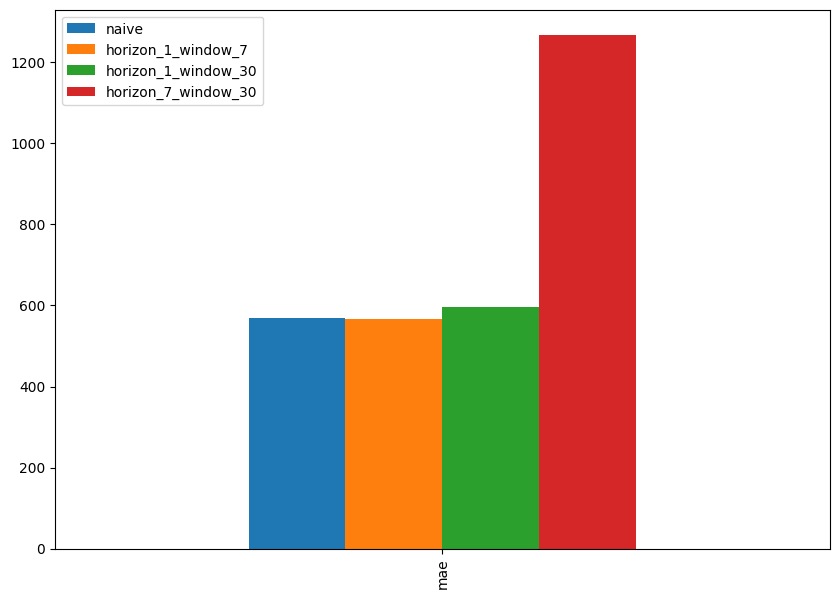

In [53]:
pd.DataFrame({"naive": naive_results["mae"], 
              "horizon_1_window_7": model_1_results["mae"], 
              "horizon_1_window_30": model_2_results["mae"], 
              "horizon_7_window_30": model_3_results["mae"]}, index=["mae"]).plot(figsize=(10, 7), kind="bar");

The Naive Bayes continues being our champion. This model is really difficult to beat in open systems

# Model 4: Conv1D

In [54]:
HORIZON = 1 # predict next day
WINDOW_SIZE = 7 # use previous week worth of data

In [55]:
# Create windowed dataset
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2780, 2780)

In [56]:
# Create train/test splits
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2224, 556, 2224, 556)

The Conv1D layer in TensorFlow takes an input of: (batch_size, timesteps, input_dim).

* timesteps = WINDOW_SIZE - the timesteps is also often referred to as features, our features are the previous WINDOW_SIZE values of Bitcoin

* input_dim = HORIZON - our model views WINDOW_SIZE (one week) worth of data at a time to predict HORIZON (one day)


Right now, our data has the timesteps dimension ready but we'll have to adjust it to have the input_dim dimension.


In [57]:
# Check data sample shapes
train_windows[0].shape # returns (WINDOW_SIZE, )


(7,)


To fix this, we could adjust the shape of all of our train_windows or we could use a tf.keras.layers.Lamdba (called a Lambda layer) to do this for us in our model.

The Lambda layer wraps a function into a layer which can be used with a model.

Let's try it out.

In [58]:

# Before we pass our data to the Conv1D layer, we have to reshape it in order to make sure it works
x = tf.constant(train_windows[0])
expand_dims_layer = layers.Lambda(lambda x: tf.expand_dims(x, axis=1)) # add an extra dimension for timesteps
print(f"Original shape: {x.shape}") # (WINDOW_SIZE)
print(f"Expanded shape: {expand_dims_layer(x).shape}") # (WINDOW_SIZE, input_dim) 
print(f"Original values with expanded shape:\n {expand_dims_layer(x)}")

Original shape: (7,)
Expanded shape: (7, 1)
Original values with expanded shape:
 [[123.65499]
 [125.455  ]
 [108.58483]
 [118.67466]
 [121.33866]
 [120.65533]
 [121.795  ]]


In [59]:
tf.random.set_seed(42)

# Create model
model_4 = tf.keras.Sequential([
  # Create Lambda layer to reshape inputs, without this layer, the model will error
  layers.Lambda(lambda x: tf.expand_dims(x, axis=1)), # resize the inputs to adjust for window size / Conv1D 3D input requirements
  layers.Conv1D(filters=128, kernel_size=5, padding="causal", activation="relu"),
  layers.Dense(HORIZON)
], name="model_4_conv1D")

# Compile model
model_4.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# Fit model
model_4.fit(train_windows,
            train_labels,
            batch_size=128, 
            epochs=100,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_4.name)])

In [60]:
model_4.summary()

Model: "model_4_conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_1 (Lambda)           (None, 1, 7)              0         
                                                                 
 conv1d (Conv1D)             (None, 1, 128)            4608      
                                                                 
 dense_6 (Dense)             (None, 1, 1)              129       
                                                                 
Total params: 4,737
Trainable params: 4,737
Non-trainable params: 0
_________________________________________________________________


In [61]:
# Load in best performing Conv1D model and evaluate it on the test data
model_4 = tf.keras.models.load_model("model_experiments/model_4_conv1D")
model_4.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 4ms/step - loss: 571.3443


571.3442993164062

In [62]:
# Evaluate predictions
# Make predictions
model_4_preds = make_preds(model_4, test_windows)
model_4_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_4_preds)
model_4_results

18/18 [==============================] - 0s 3ms/step


{'mae': 571.34424,
 'mse': 1181054.5,
 'rmse': 1086.7633,
 'mape': 2.5559847,
 'mase': 1.0036936}

# Model 5: RNN (LSTM)

Once again, one of the most important steps for the LSTM model will be getting our data into the right shape.

The tf.keras.layers.LSTM() layer takes a tensor with [batch, timesteps, feature] dimensions.

As mentioned earlier, the batch dimension gets taken care of for us but our data is currently only has the feature dimension (WINDOW_SIZE).

To fix this, just like we did with the Conv1D model, we can use a tf.keras.layers.Lambda() layer to adjust the shape of our input tensors to the LSTM layer

In [63]:
tf.random.set_seed(42)

# Let's build an LSTM model with the Functional API
inputs = layers.Input(shape=(WINDOW_SIZE))
x = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(inputs) # expand input dimension to be compatible with LSTM
print(x.shape)
# x = layers.LSTM(128, activation="relu", return_sequences=True)(x) # this layer will error if the inputs are not the right shape
x = layers.LSTM(128, activation="relu")(x) # using the tanh loss function results in a massive error
# print(x.shape)
# Add another optional dense layer (you could add more of these to see if they improve model performance)
# x = layers.Dense(32, activation="relu")(x)
output = layers.Dense(HORIZON)(x)
model_5 = tf.keras.Model(inputs=inputs, outputs=output, name="model_5_lstm")

# Compile model
model_5.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# Seems when saving the model several warnings are appearing: https://github.com/tensorflow/tensorflow/issues/47554 
model_5.fit(train_windows,
            train_labels,
            epochs=100,
            verbose=0,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_5.name)])

(None, 1, 7)


In [64]:
# Load in best version of model 5 and evaluate on the test data
model_5 = tf.keras.models.load_model("model_experiments/model_5_lstm/")
model_5.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 3ms/step - loss: 582.2452


582.2452392578125

In [65]:
# Make predictions with our LSTM model
model_5_preds = make_preds(model_5, test_windows)
# Evaluate model 5 preds
model_5_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_5_preds)
model_5_results

18/18 [==============================] - 0s 2ms/step


{'mae': 582.2452,
 'mse': 1225503.1,
 'rmse': 1107.0244,
 'mape': 2.6449344,
 'mase': 1.0228435}


# Make a multivariate time series

So far, we have been using just one variable to predict the bitcoin value, we are using the same bitcoin value is an early time.

In this occasion we are going to add an extra variable. The bitcoin block reward.

 Adding an extra feature to our dataset such as the Bitcoin block reward size will take our data from univariate (only the historical price of Bitcoin) to multivariate (the price of Bitcoin as well as the block reward size).

In [66]:
# Let's make a multivariate time series
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


In [67]:
# Block reward values
block_reward_1 = 50 # 3 January 2009 (2009-01-03) - this block reward isn't in our dataset (it starts from 01 October 2013)
block_reward_2 = 25 # 28 November 2012 
block_reward_3 = 12.5 # 9 July 2016
block_reward_4 = 6.25 # 11 May 2020

# Block reward dates (datetime form of the above date stamps)
block_reward_2_datetime = np.datetime64("2012-11-28")
block_reward_3_datetime = np.datetime64("2016-07-09")
block_reward_4_datetime = np.datetime64("2020-05-11")

In [68]:
# Get date indexes for when to add in different block dates
block_reward_2_days = (block_reward_3_datetime - bitcoin_prices.index[0]).days #the difference between the day the block reward changed and the
#first date in ourt dataframe
block_reward_3_days = (block_reward_4_datetime - bitcoin_prices.index[0]).days
block_reward_2_days, block_reward_3_days

(1012, 2414)

In [69]:
# Add block_reward column
bitcoin_prices_block = bitcoin_prices.copy()
bitcoin_prices_block["block_reward"] = None

# Set values of block_reward column (it's the last column hence -1 indexing on iloc)
bitcoin_prices_block.iloc[:block_reward_2_days, -1] = block_reward_2
bitcoin_prices_block.iloc[block_reward_2_days:block_reward_3_days, -1] = block_reward_3
bitcoin_prices_block.iloc[block_reward_3_days:, -1] = block_reward_4
bitcoin_prices_block.head()

,Price,block_reward
Date,,
2013-10-01,123.65499,25
2013-10-02,125.45500,25
2013-10-03,108.58483,25
2013-10-04,118.67466,25
2013-10-05,121.33866,25


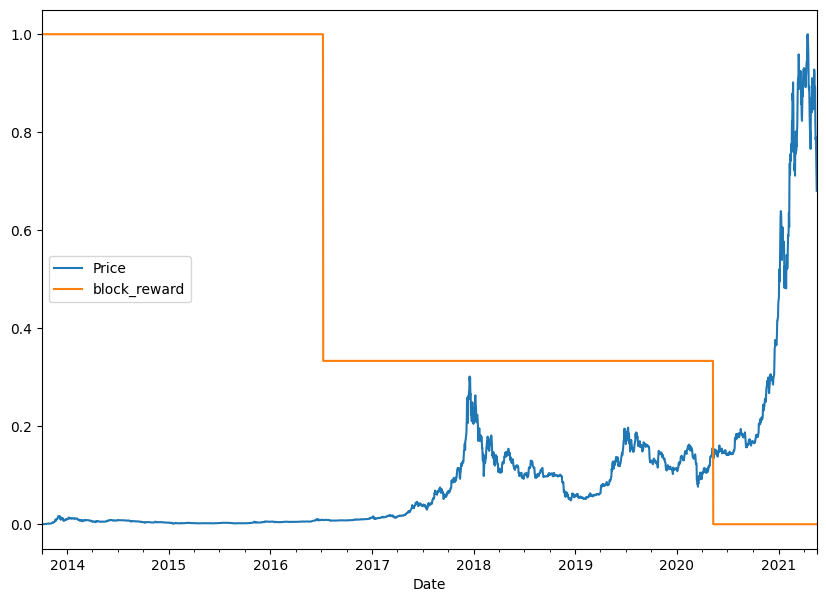

In [70]:
# Plot the block reward/price over time
# Note: Because of the different scales of our values we'll scale them to be between 0 and 1.
from sklearn.preprocessing import minmax_scale
scaled_price_block_df = pd.DataFrame(minmax_scale(bitcoin_prices_block[["Price", "block_reward"]]), # we need to scale the data first
                                     columns=bitcoin_prices_block.columns,
                                     index=bitcoin_prices_block.index)
scaled_price_block_df.plot(figsize=(10, 7));

# Making a windowed dataset with pandas

Since our data is in a pandas DataFrame, we can leverage the `pandas.DataFrame.shift()` method to create a windowed multivariate time series.

In [71]:
# Setup dataset hyperparameters
HORIZON = 1
WINDOW_SIZE = 7

In [72]:
# Make a copy of the Bitcoin historical data with block reward feature
bitcoin_prices_windowed = bitcoin_prices_block.copy()

# Add windowed columns
for i in range(WINDOW_SIZE): # Shift values for each step in WINDOW_SIZE
  bitcoin_prices_windowed[f"Price+{i+1}"] = bitcoin_prices_windowed["Price"].shift(periods=i+1)
bitcoin_prices_windowed.head(10)

,Price,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,
2013-10-01,123.65499,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-02,125.45500,25,123.65499,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-03,108.58483,25,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN
2013-10-04,118.67466,25,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN
2013-10-05,121.33866,25,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN
2013-10-06,120.65533,25,121.33866,118.67466,108.58483,125.45500,123.65499,NaN,NaN
2013-10-07,121.79500,25,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499,NaN
2013-10-08,123.03300,25,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499
2013-10-09,124.04900,25,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500



Now that we've got a windowed dataset, let's separate features (X) from labels (y)

Removing the `nans`


In [73]:
# Let's create X & y, remove the NaN's and convert to float32 to prevent TensorFlow errors 
X = bitcoin_prices_windowed.dropna().drop("Price", axis=1).astype(np.float32) 
y = bitcoin_prices_windowed.dropna()["Price"].astype(np.float32)
X.head()

,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2013-10-08,25.0,121.794998,120.655327,121.338661,118.674660,108.584831,125.455002,123.654991
2013-10-09,25.0,123.032997,121.794998,120.655327,121.338661,118.674660,108.584831,125.455002
2013-10-10,25.0,124.049004,123.032997,121.794998,120.655327,121.338661,118.674660,108.584831
2013-10-11,25.0,125.961159,124.049004,123.032997,121.794998,120.655327,121.338661,118.674660
2013-10-12,25.0,125.279663,125.961159,124.049004,123.032997,121.794998,120.655327,121.338661


In [74]:
# Make train and test sets
split_size = int(len(X) * 0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
len(X_train), len(y_train), len(X_test), len(y_test)


(2224, 2224, 556, 556)

**coool 🐊** We have added a new variable (block reward) and turned our single variate problem into multivariate problem. Additionally, we have obtained or training and test data 

**Time to build some models ans try them out**


# Model 6: Dense (multivariate time series)

You can notice this model is exact as the one we used before (with singlevariate). You don't have to specify the input

In [75]:
tf.random.set_seed(42)

# Make multivariate time series model
model_6 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  # layers.Dense(128, activation="relu"), # adding an extra layer here should lead to beating the naive model
  layers.Dense(HORIZON)
], name="model_6_dense_multivariate")

# Compile
model_6.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# Fit
model_6.fit(X_train, y_train,
            epochs=100,
            batch_size=128,
            verbose=0, # only print 1 line per epoch
            validation_data=(X_test, y_test),
            callbacks=[create_model_checkpoint(model_name=model_6.name)])

In [76]:
# Make sure best model is loaded and evaluate
model_6 = tf.keras.models.load_model("model_experiments/model_6_dense_multivariate")
model_6.evaluate(X_test, y_test)

18/18 [==============================] - 0s 2ms/step - loss: 567.3650


567.364990234375

In [77]:
# Make predictions on multivariate data
model_6_preds = tf.squeeze(model_6.predict(X_test))
model_6_preds[:10]

18/18 [==============================] - 0s 2ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8853.994, 8761.229, 9033.171, 8782.253, 8713.235, 8754.135,
       8671.151, 8514.904, 8456.006, 8523.251], dtype=float32)>

In [78]:
# Evaluate preds
model_6_results = evaluate_preds(y_true=y_test,
                                 y_pred=model_6_preds)
model_6_results

{'mae': 567.36505,
 'mse': 1166258.6,
 'rmse': 1079.9346,
 'mape': 2.5310953,
 'mase': 0.99670327}

Let's compare with the same model but without the extra feature

In [79]:
model_1_results

{'mae': 565.7584,
 'mse': 1155034.0,
 'rmse': 1074.7251,
 'mape': 2.551753,
 'mase': 0.99388087}

It seens like it haven't improved

# Model 7: N-BEATS algorithm
(N-BEATS: NEURAL BASIS EXPANSION ANALYSIS FOR
INTERPRETABLE TIME SERIES FORECASTING)

* The N-BEATS algorithm focuses on univariate time series problems and achieved state-of-the-art performance in the winner of the M4 competition 

* For our next modelling experiment we're going to be replicating the generic architecture of the N-BEATS algorithm 

In this exercise we are going to create a **custome layer**

In [80]:
# Create NBeatsBlock custom layer 
class NBeatsBlock(tf.keras.layers.Layer):
  def __init__(self, # the constructor takes all the hyperparameters for the layer
               input_size: int,
               theta_size: int,
               horizon: int,
               n_neurons: int,
               n_layers: int,
               **kwargs): # the **kwargs argument takes care of all of the arguments for the parent class (input_shape, trainable, name)
    super().__init__(**kwargs)
    self.input_size = input_size
    self.theta_size = theta_size
    self.horizon = horizon
    self.n_neurons = n_neurons
    self.n_layers = n_layers

    # Block contains stack of 4 fully connected layers each has ReLU activation
    self.hidden = [tf.keras.layers.Dense(n_neurons, activation="relu") for _ in range(n_layers)]
    # Output of block is a theta layer with linear activation
    self.theta_layer = tf.keras.layers.Dense(theta_size, activation="linear", name="theta")

  def call(self, inputs): # the call method is what runs when the layer is called 
    x = inputs 
    for layer in self.hidden: # pass inputs through each hidden layer 
      x = layer(x)
    theta = self.theta_layer(x) 
    # Output the backcast and forecast from theta
    backcast, forecast = theta[:, :self.input_size], theta[:, -self.horizon:]
    return backcast, forecast

In [81]:
# Set up dummy NBeatsBlock layer to represent inputs and outputs
dummy_nbeats_block_layer = NBeatsBlock(input_size=WINDOW_SIZE, 
                                       theta_size=WINDOW_SIZE+HORIZON, # backcast + forecast 
                                       horizon=HORIZON,
                                       n_neurons=128,
                                       n_layers=4)

In [82]:
# Create dummy inputs (have to be same size as input_size)
dummy_inputs = tf.expand_dims(tf.range(WINDOW_SIZE) + 1, axis=0) # input shape to the model has to reflect Dense layer input requirements (ndim=2)
dummy_inputs

<tf.Tensor: shape=(1, 7), dtype=int32, numpy=array([[1, 2, 3, 4, 5, 6, 7]], dtype=int32)>

In [83]:
# Pass dummy inputs to dummy NBeatsBlock layer
backcast, forecast = dummy_nbeats_block_layer(dummy_inputs)
# These are the activation outputs of the theta layer (they'll be random due to no training of the model)
print(f"Backcast: {tf.squeeze(backcast.numpy())}")
print(f"Forecast: {tf.squeeze(forecast.numpy())}")

Backcast: [-0.34939957  0.5550779   0.60382015  0.09947461  0.26087248  0.42115447
 -0.3449294 ]
Forecast: -1.0397906303405762



# Preparing data for the N-BEATS algorithm using `tf.data`

This time, because we're going to be using a larger model architecture, to ensure our model training runs as fast as possible, we'll setup our datasets using the tf.data API

Turning the arrays in tensor Datasets using tf.data.Dataset.from_tensor_slices()
Note: from_tensor_slices() works best when your data fits in memory, for extremely large datasets, you'll want to look into using the TFRecord format (https://www.tensorflow.org/tutorials/load_data/tfrecord)

In [84]:
HORIZON = 1 # how far to predict forward
WINDOW_SIZE = 7 # how far to lookback

In [85]:
# Add windowed columns
bitcoin_prices_nbeats = bitcoin_prices.copy()
for i in range(WINDOW_SIZE):
  bitcoin_prices_nbeats[f"Price+{i+1}"] = bitcoin_prices_nbeats["Price"].shift(periods=i+1)
bitcoin_prices_nbeats.dropna().head()

,Price,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2013-10-08,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499
2013-10-09,124.04900,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500
2013-10-10,125.96116,124.04900,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483
2013-10-11,125.27966,125.96116,124.04900,123.03300,121.79500,120.65533,121.33866,118.67466
2013-10-12,125.92750,125.27966,125.96116,124.04900,123.03300,121.79500,120.65533,121.33866


In [86]:
# Make features and labels
X = bitcoin_prices_nbeats.dropna().drop("Price", axis=1)
y = bitcoin_prices_nbeats.dropna()["Price"]

# Make train and test sets
split_size = int(len(X) * 0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
len(X_train), len(y_train), len(X_test), len(y_test)

(2224, 2224, 556, 556)

In [87]:
# 1. Turn train and test arrays into tensor Datasets
train_features_dataset = tf.data.Dataset.from_tensor_slices(X_train)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)

test_features_dataset = tf.data.Dataset.from_tensor_slices(X_test)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)

# 2. Combine features & labels
train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset))
test_dataset = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset))

# 3. Batch and prefetch for optimal performance
BATCH_SIZE = 1024 # taken from Appendix D in N-BEATS paper
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_dataset, test_dataset

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>)

### Let's define our hyperparameters for the creation of our model

In [88]:
# Values from N-BEATS paper Figure 1 and Table 18/Appendix D
N_EPOCHS = 5000 # called "Iterations" in Table 18
N_NEURONS = 512 # called "Width" in Table 18
N_LAYERS = 4
N_STACKS = 30

INPUT_SIZE = WINDOW_SIZE * HORIZON # called "Lookback" in Table 18
THETA_SIZE = INPUT_SIZE + HORIZON

INPUT_SIZE, THETA_SIZE

(7, 8)

Getting ready for residual connections
Beautiful! Hyperparameters ready, now before we create the N-BEATS model, there are two layers to go through which play a large roll in the architecture.

They're what make N-BEATS double residual stacking (section 3.2 of the N-BEATS paper) possible:

* tf.keras.layers.subtract(inputs) - subtracts list of input tensors from each other

* tf.keras.layers.add(inputs) - adds list of input tensors to each other
Let's try them out.

In [89]:
# Make tensors
tensor_1 = tf.range(10) + 10
tensor_2 = tf.range(10)

# Subtract
subtracted = layers.subtract([tensor_1, tensor_2])

# Add
added = layers.add([tensor_1, tensor_2])

print(f"Input tensors: {tensor_1.numpy()} & {tensor_2.numpy()}")
print(f"Subtracted: {subtracted.numpy()}")
print(f"Added: {added.numpy()}")

Input tensors: [10 11 12 13 14 15 16 17 18 19] & [0 1 2 3 4 5 6 7 8 9]
Subtracted: [10 10 10 10 10 10 10 10 10 10]
Added: [10 12 14 16 18 20 22 24 26 28]



Both of these layer functions are straight-forward, subtract or add together their inputs.

And as mentioned before, **they're what powers N-BEATS double residual stacking.**

In [90]:
 %%time

tf.random.set_seed(42)

# 1. Setup N-BEATS Block layer
nbeats_block_layer = NBeatsBlock(input_size=INPUT_SIZE,
                                 theta_size=THETA_SIZE,
                                 horizon=HORIZON,
                                 n_neurons=N_NEURONS,
                                 n_layers=N_LAYERS,
                                 name="InitialBlock")

# 2. Create input to stacks
stack_input = layers.Input(shape=(INPUT_SIZE), name="stack_input")

# 3. Create initial backcast and forecast input (backwards predictions are referred to as residuals in the paper)
backcast, forecast = nbeats_block_layer(stack_input)
# Add in subtraction residual link, thank you to: https://github.com/mrdbourke/tensorflow-deep-learning/discussions/174 
residuals = layers.subtract([stack_input, backcast], name=f"subtract_00") 

# 4. Create stacks of blocks
for i, _ in enumerate(range(N_STACKS-1)): # first stack is already creted in (3)

  # 5. Use the NBeatsBlock to calculate the backcast as well as block forecast
  backcast, block_forecast = NBeatsBlock(
      input_size=INPUT_SIZE,
      theta_size=THETA_SIZE,
      horizon=HORIZON,
      n_neurons=N_NEURONS,
      n_layers=N_LAYERS,
      name=f"NBeatsBlock_{i}"
  )(residuals) # pass it in residuals (the backcast)

  # 6. Create the double residual stacking
  residuals = layers.subtract([residuals, backcast], name=f"subtract_{i}") 
  forecast = layers.add([forecast, block_forecast], name=f"add_{i}")

# 7. Put the stack model together
model_7 = tf.keras.Model(inputs=stack_input, 
                         outputs=forecast, 
                         name="model_7_N-BEATS")

# 8. Compile with MAE loss and Adam optimizer
model_7.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(0.001),
                metrics=["mae", "mse"])

# 9. Fit the model with EarlyStopping and ReduceLROnPlateau callbacks
model_7.fit(train_dataset,
            epochs=N_EPOCHS,
            validation_data=test_dataset,
            verbose=0, # prevent large amounts of training outputs
            # callbacks=[create_model_checkpoint(model_name=stack_model.name)] # saving model every epoch consumes far too much time
            callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=200, restore_best_weights=True),
                      tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=100, verbose=1)])


Epoch 140: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 240: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
CPU times: user 1min 38s, sys: 2 s, total: 1min 40s
Wall time: 1min 46s


In [91]:
# Evaluate N-BEATS model on the test dataset
model_7.evaluate(test_dataset)

1/1 [==============================] - 0s 27ms/step - loss: 575.3050 - mae: 575.3050 - mse: 1161964.3750


[575.3049926757812, 575.3049926757812, 1161964.375]

In [92]:
# Make predictions with N-BEATS model
model_7_preds = make_preds(model_7, test_dataset)
model_7_preds[:10]

1/1 [==============================] - 1s 1s/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8840.3955, 8766.831 , 9058.956 , 8756.776 , 8632.863 , 8727.241 ,
       8690.901 , 8456.763 , 8446.8545, 8522.004 ], dtype=float32)>

In [93]:
# Evaluate N-BEATS model predictions
model_7_results = evaluate_preds(y_true=y_test,
                                 y_pred=model_7_preds)
model_7_results

{'mae': 575.305,
 'mse': 1161964.4,
 'rmse': 1077.9446,
 'mape': 2.6276524,
 'mase': 1.0106515}

Even this complex network is not as good as Naive Bayes 

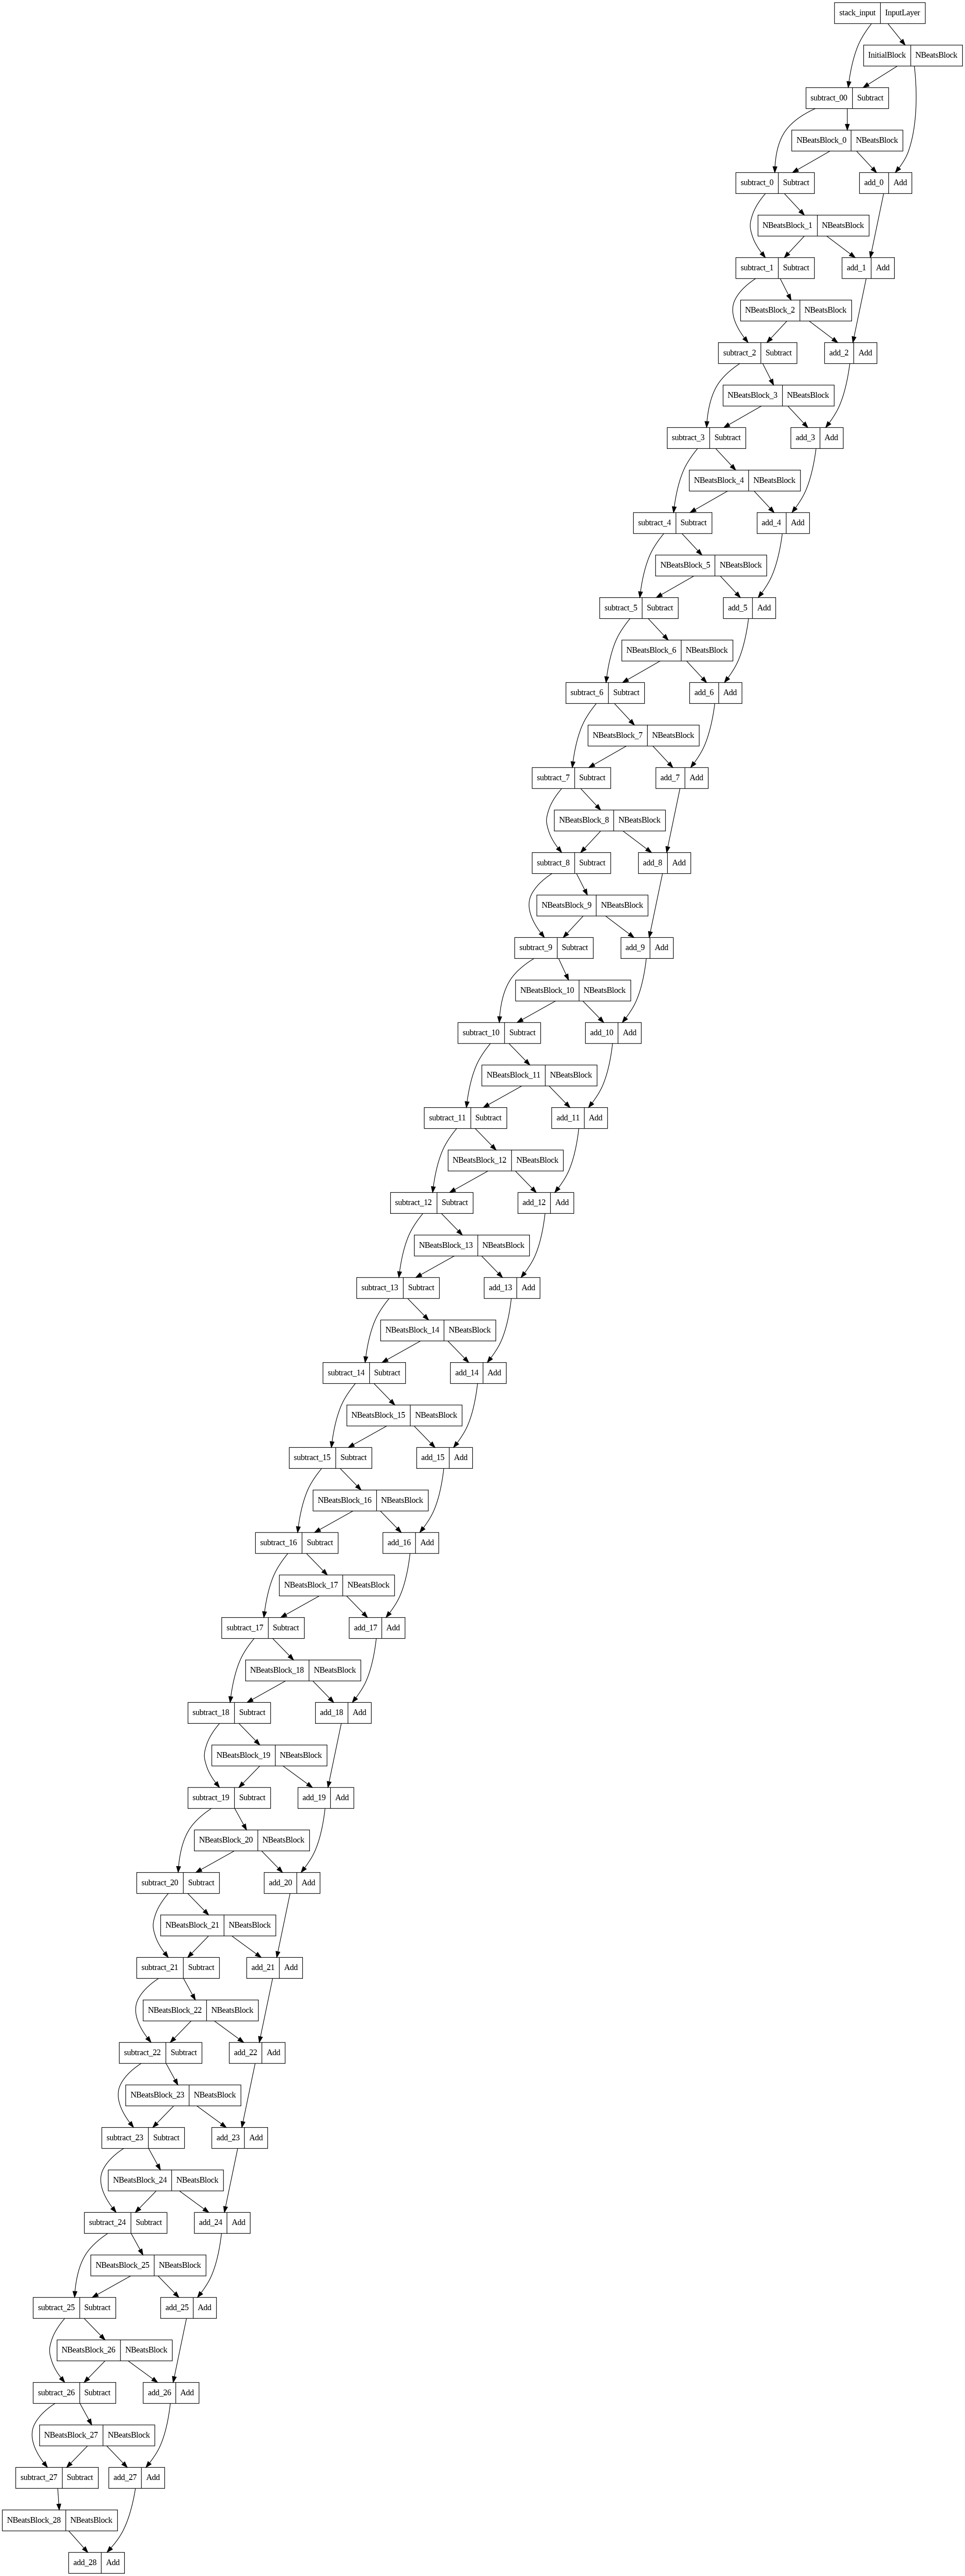

In [94]:
plot_model(model_7)

In [95]:
# This will error out unless a "get_config()" method is implemented - this could be extra curriculum
model_7.save(model_7.name)

# Model 8: Creating an ensemble (stacking different models together)

After all that effort, the N-BEATS algorithm's performance was underwhelming.

But again, this is part of the parcel of machine learning. Not everything will work.

That's when we refer back to the motto: experiment, experiment, experiment.

Our next experiment is creating an ensemble of models.

An ensemble involves training and combining multiple different models on the same problem. **Ensemble models are often the types of models you'll see winning data science competitions on websites like Kaggle**

In [96]:
def get_ensemble_models(horizon=HORIZON, 
                        train_data=train_dataset,
                        test_data=test_dataset,
                        num_iter=10, 
                        num_epochs=100, 
                        loss_fns=["mae", "mse", "mape"]):
  """
  Returns a list of num_iter models each trained on MAE, MSE and MAPE loss.

  For example, if num_iter=10, a list of 30 trained models will be returned:
  10 * len(["mae", "mse", "mape"]).
  """
  # Make empty list for trained ensemble models
  ensemble_models = []

  # Create num_iter number of models per loss function
  for i in range(num_iter):
    # Build and fit a new model with a different loss function
    for loss_function in loss_fns:
      print(f"Optimizing model by reducing: {loss_function} for {num_epochs} epochs, model number: {i}")

      # Construct a simple model (similar to model_1)
      model = tf.keras.Sequential([
        # Initialize layers with normal (Gaussian) distribution so we can use the models for prediction
        # interval estimation later: https://www.tensorflow.org/api_docs/python/tf/keras/initializers/HeNormal
        layers.Dense(128, kernel_initializer="he_normal", activation="relu"), 
        layers.Dense(128, kernel_initializer="he_normal", activation="relu"),
        layers.Dense(HORIZON)                                 
      ])

      # Compile simple model with current loss function
      model.compile(loss=loss_function,
                    optimizer=tf.keras.optimizers.Adam(),
                    metrics=["mae", "mse"])
      
      # Fit model
      model.fit(train_data,
                epochs=num_epochs,
                verbose=0,
                validation_data=test_data,
                # Add callbacks to prevent training from going/stalling for too long
                callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                            patience=200,
                                                            restore_best_weights=True),
                           tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                                patience=100,
                                                                verbose=1)])
      
      # Append fitted model to list of ensemble models
      ensemble_models.append(model)

  return ensemble_models # return list of trained models

In principle, if we train the same model several times with the same data we will obtain the same result, but due to random initialization of variables, even doing this, we can obtain different results.

This is exactly what we are going to do, we are going to create n times se same model with different metrics and see if this can give an improvement 

In [97]:
%%time
# Get list of trained ensemble models
ensemble_models = get_ensemble_models(num_iter=5,
                                      num_epochs=1000)

Optimizing model by reducing: mae for 1000 epochs, model number: 0

Epoch 333: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Optimizing model by reducing: mse for 1000 epochs, model number: 0

Epoch 648: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 748: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Optimizing model by reducing: mape for 1000 epochs, model number: 0

Epoch 163: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 273: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 373: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Optimizing model by reducing: mae for 1000 epochs, model number: 1
Optimizing model by reducing: mse for 1000 epochs, model number: 1

Epoch 652: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 752: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Optimizing model by redu

Let's write a function to make predictions with each model inside the ensamble of models and store those predictions


In [98]:
# Create a function which uses a list of trained models to make and return a list of predictions
def make_ensemble_preds(ensemble_models, data):
  ensemble_preds = []
  for model in ensemble_models:
    preds = model.predict(data) # make predictions with current ensemble model
    ensemble_preds.append(preds)
  return tf.constant(tf.squeeze(ensemble_preds))

In [99]:
# Create a list of ensemble predictions
ensemble_preds = make_ensemble_preds(ensemble_models=ensemble_models,
                                     data=test_dataset)
ensemble_preds

1/1 [==============================] - 0s 37ms/step


1/1 [==============================] - 0s 40ms/step


1/1 [==============================] - 0s 39ms/step


<tf.Tensor: shape=(15, 556), dtype=float32, numpy=
array([[ 8759.273 ,  8741.939 ,  9018.467 , ..., 50193.758 , 48960.79  ,
        46038.395 ],
       [ 8762.935 ,  8769.808 ,  9076.4795, ..., 50347.99  , 48197.996 ,
        45974.13  ],
       [ 8812.5625,  8758.018 ,  9019.728 , ..., 49816.598 , 47957.457 ,
        46394.207 ],
       ...,
       [ 8685.93  ,  8607.343 ,  8979.151 , ..., 49956.957 , 47745.58  ,
        45288.426 ],
       [ 8794.723 ,  8742.254 ,  9006.757 , ..., 49818.465 , 49003.293 ,
        46619.89  ],
       [ 8827.567 ,  8779.494 ,  9105.621 , ..., 50127.062 , 48434.113 ,
        46476.48  ]], dtype=float32)>

However, since we've trained 15 models, there's going to be 15 sets of predictions. Rather than comparing every set of predictions to the ground truth, let's take the median (you could also take the mean too but the median is usually more robust than the mean).

In [100]:
# Evaluate ensemble model(s) predictions
ensemble_results = evaluate_preds(y_true=y_test,
                                  y_pred=np.median(ensemble_preds, axis=0)) # take the median across all ensemble predictions
ensemble_results

{'mae': 569.4202,
 'mse': 1141061.8,
 'rmse': 1068.205,
 'mape': 2.5797038,
 'mase': 1.0003136}

### Niceee 💅. Now we have an ensamble of predictions. Using this ensamble we can also obtain the error within the ensamble. This is useful for not only know the possible value, but also the uncertainty around that value.

So let's compute the uncertainty prediction in our ensamble of models. If we asssume our predictions follow a **Gaussian distribution** we can do it with the following steps:

1. Take the predictions from a number of randomly initialized models (we've got this thanks to our ensemble model)
2. Measure the standard deviation of the predictions
3. Multiply standard deviation by 1.96 (assuming the distribution is Gaussian, 95% of observations fall within 1.96 standard deviations of the mean, this is why we initialized our neural networks with a normal distribution)
4. To get the prediction interval upper and lower bounds, add and subtract the value obtained in (3) to the mean/median of the predictions made in (1)

In [101]:
# Find upper and lower bounds of ensemble predictions
def get_upper_lower(preds): # 1. Take the predictions of multiple randomly initialized deep learning neural networks
  
  # 2. Measure the standard deviation of the predictions
  std = tf.math.reduce_std(preds, axis=0)
  
  # 3. Multiply the standard deviation by 1.96
  interval = 1.96 * std # https://en.wikipedia.org/wiki/1.96 

  # 4. Get the prediction interval upper and lower bounds
  preds_mean = tf.reduce_mean(preds, axis=0)
  lower, upper = preds_mean - interval, preds_mean + interval
  return lower, upper

# Get the upper and lower bounds of the 95% 
lower, upper = get_upper_lower(preds=ensemble_preds)

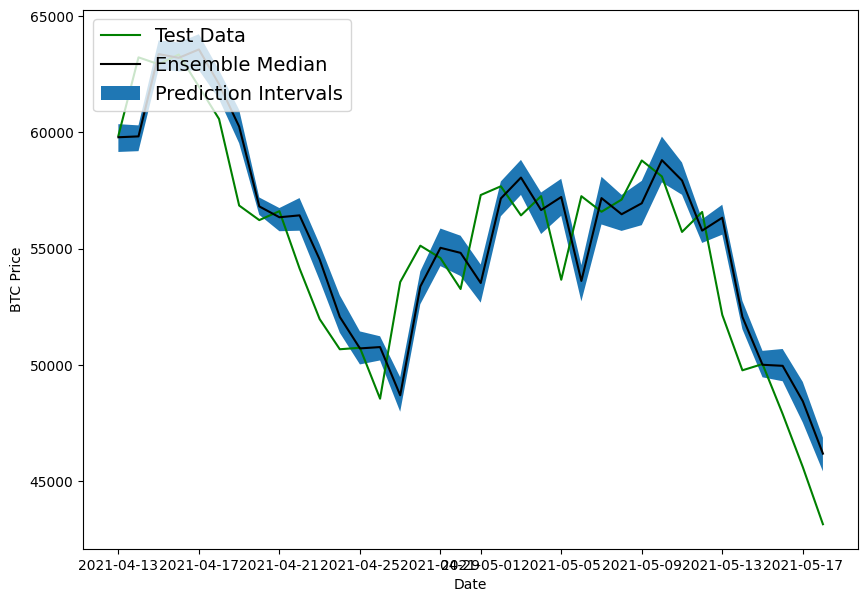

In [116]:
# Get the median values of our ensemble preds
ensemble_median = np.median(ensemble_preds, axis=0)

# Plot the median of our ensemble preds along with the prediction intervals (where the predictions fall between)
offset=520
plt.figure(figsize=(10, 7))
plt.plot(X_test.index[offset:], y_test[offset:], "g", label="Test Data")
plt.plot(X_test.index[offset:], ensemble_median[offset:], "k-", label="Ensemble Median")
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.fill_between(X_test.index[offset:], 
                 (lower)[offset:], 
                 (upper)[offset:], label="Prediction Intervals")
plt.legend(loc="upper left", fontsize=14);

# **Addtional material**

* https://towardsdatascience.com/3-facts-about-time-series-forecasting-that-surprise-experienced-machine-learning-practitioners-69c18ee89387

* https://towardsdatascience.com/how-not-to-use-machine-learning-for-time-series-forecasting-avoiding-the-pitfalls-19f9d7adf424

* https://arxiv.org/pdf/1512.03385.pdf

* https://arxiv.org/pdf/1905.10437.pdf

* https://www.johndcook.com/blog/2009/03/06/student-t-distribution-mean-median/